In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220624_VARprocess_EC_50subjects_180.0s_segment_3600.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010083_EC    10
sub-010090_EC    10
sub-010041_EC    10
sub-010064_EC     8
sub-010079_EC    10
sub-010104_EC    10
sub-010200_EC    10
sub-010148_EC    10
sub-010005_EC    10
sub-010061_EC    10
sub-010072_EC    10
sub-010136_EC    10
sub-010092_EC     9
sub-010059_EC    10
sub-010021_EC    10
sub-010070_EC    10
sub-010056_EC    10
sub-010040_EC    10
sub-010062_EC    10
sub-010183_EC    10
sub-010024_EC    10
sub-010089_EC    10
sub-010091_EC    10
sub-010146_EC    10
sub-010032_EC     9
sub-010085_EC    10
sub-010045_EC    10
sub-010012_EC    10
sub-010137_EC    10
sub-010071_EC    10
sub-010261_EC    10
sub-010222_EC     9
sub-010242_EC    10
sub-010317_EC    10
sub-010224_EC    10
sub-010241_EC    10
sub-010315_EC    10
sub-010249_EC    10
sub-010250_EC    10
sub-010260_EC    10
sub-010258_EC    10
sub-010266_EC    10
sub-010263_EC    10
sub-010300_EC    10
sub-010305_EC    10
sub-010252_EC    10
sub-010299_EC    10
sub-010319_EC    10
sub-010297_EC    10
sub-010251_EC    10


10.0

9.9

<AxesSubplot:xlabel='order', ylabel='AIC'>

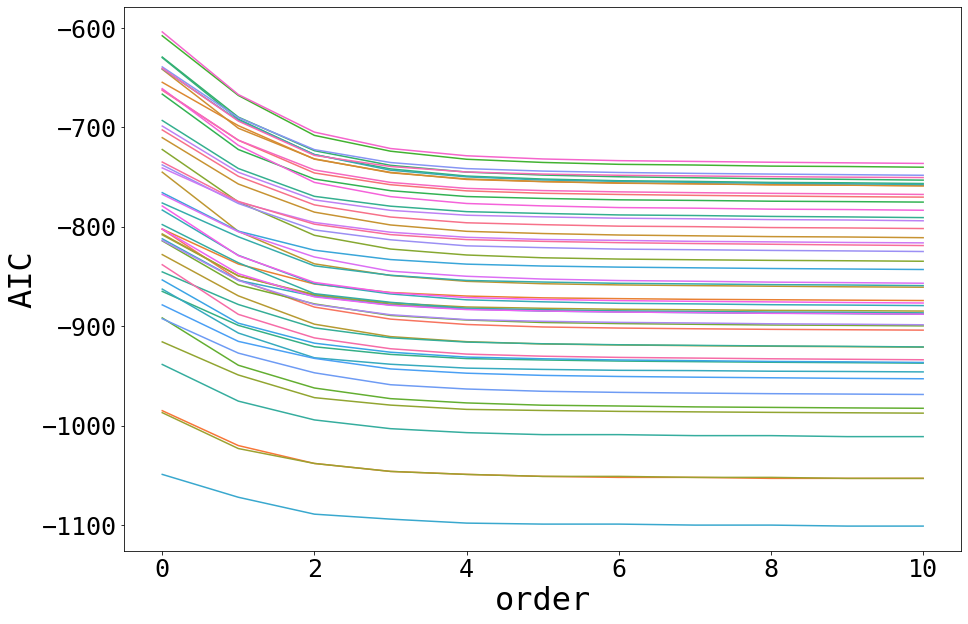

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_39345/1854914166.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_39345/1854914166.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


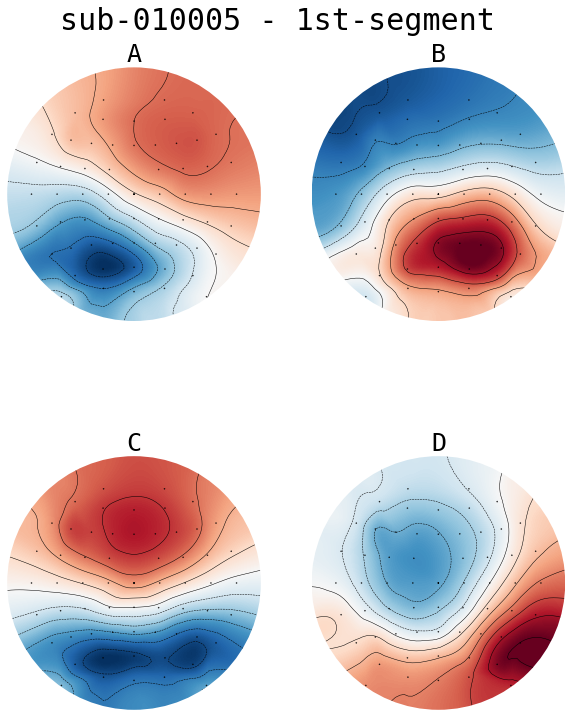

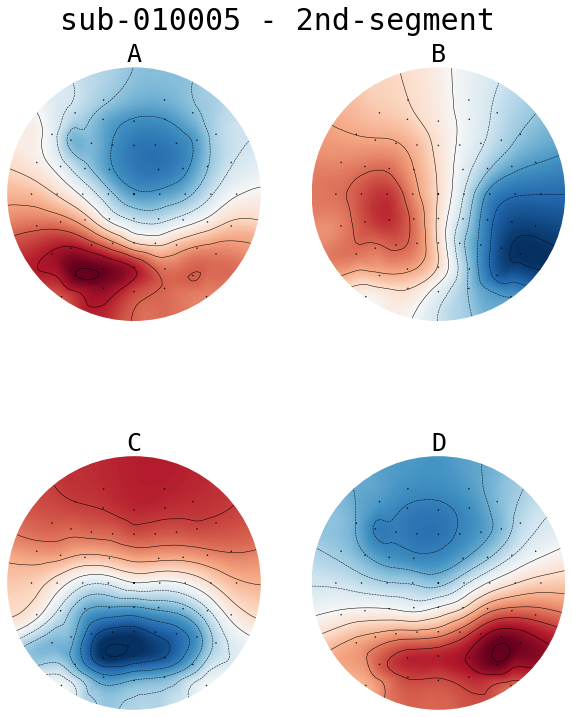

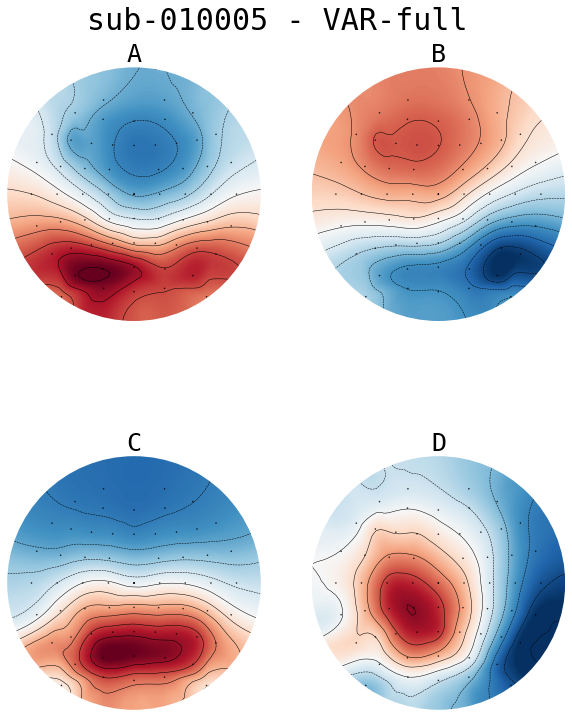

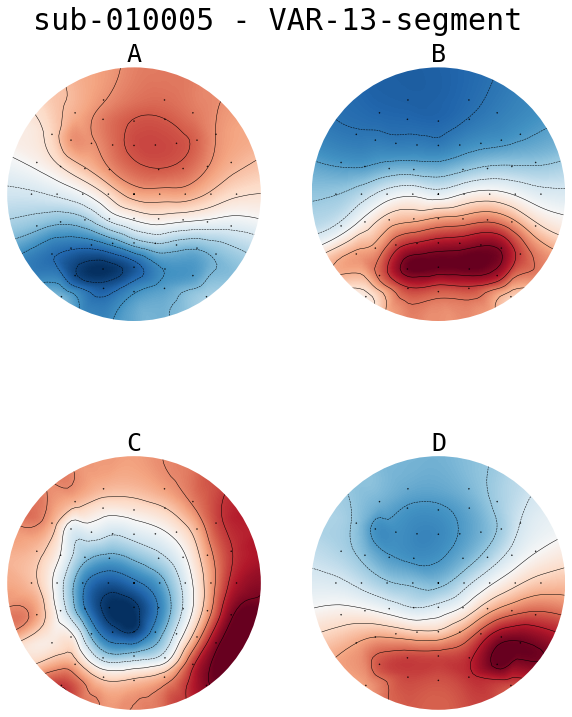

In [5]:
subj_id = "sub-010005"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-13-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

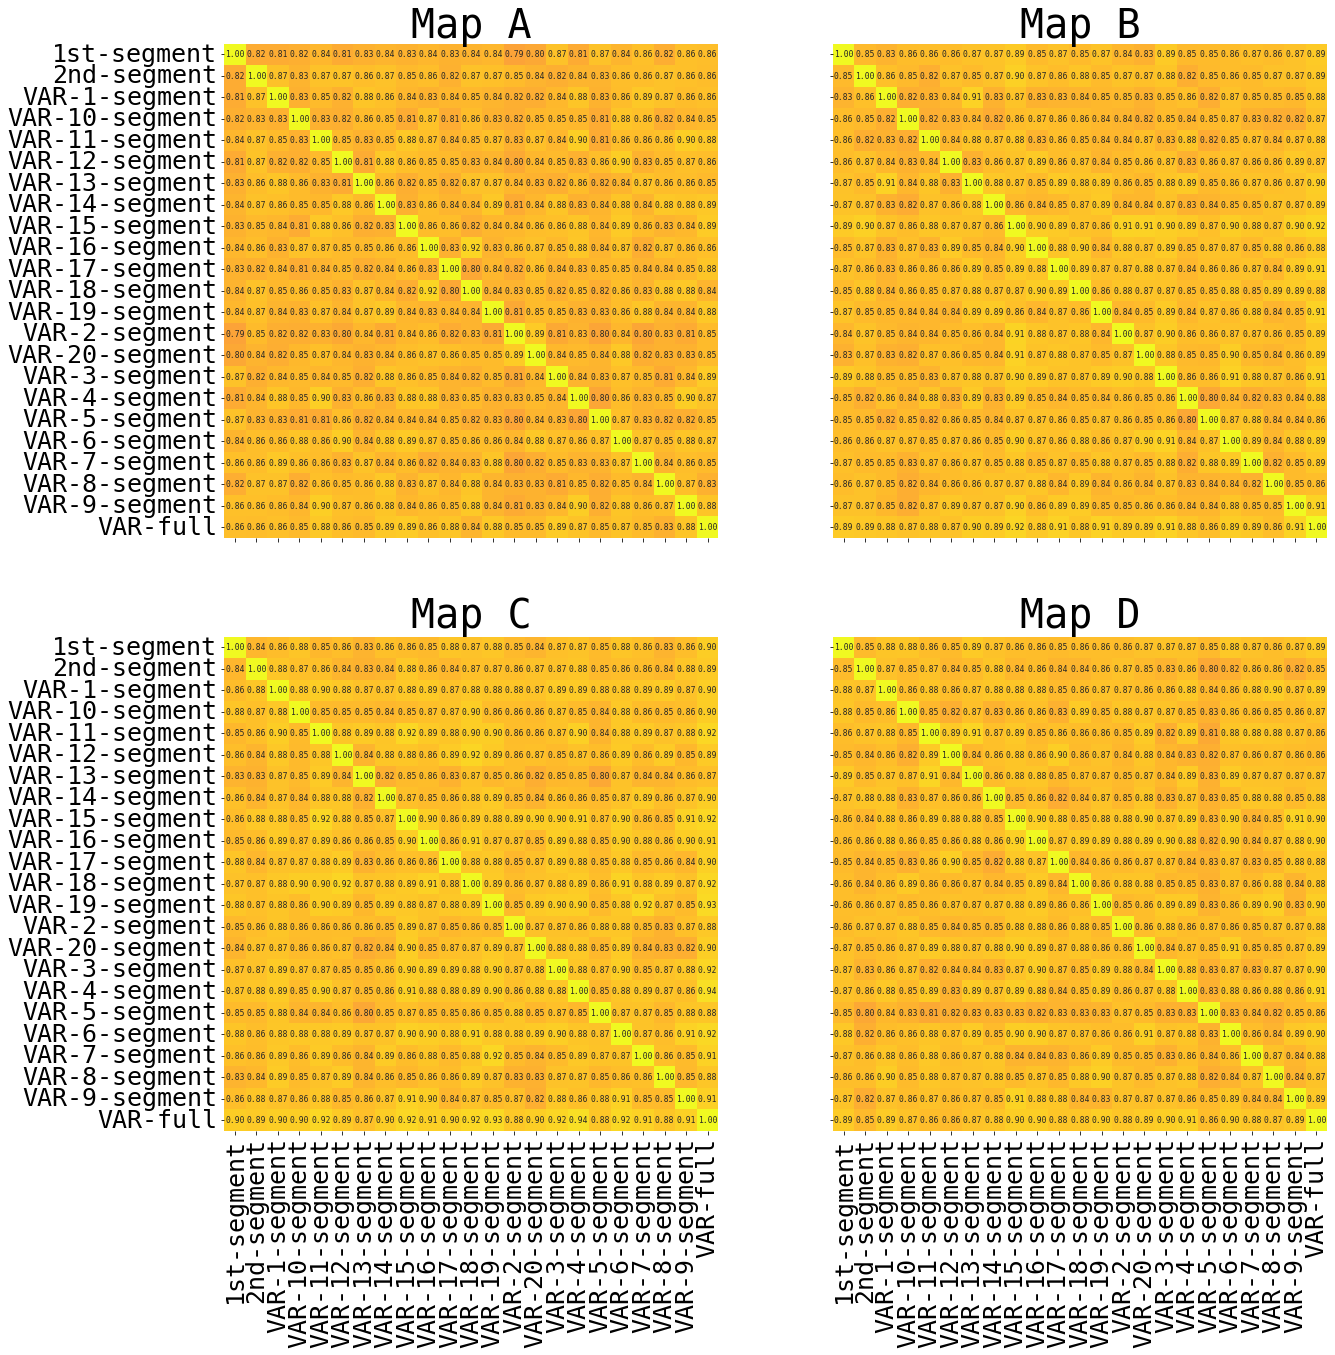

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [01:33<00:00, 240.09it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

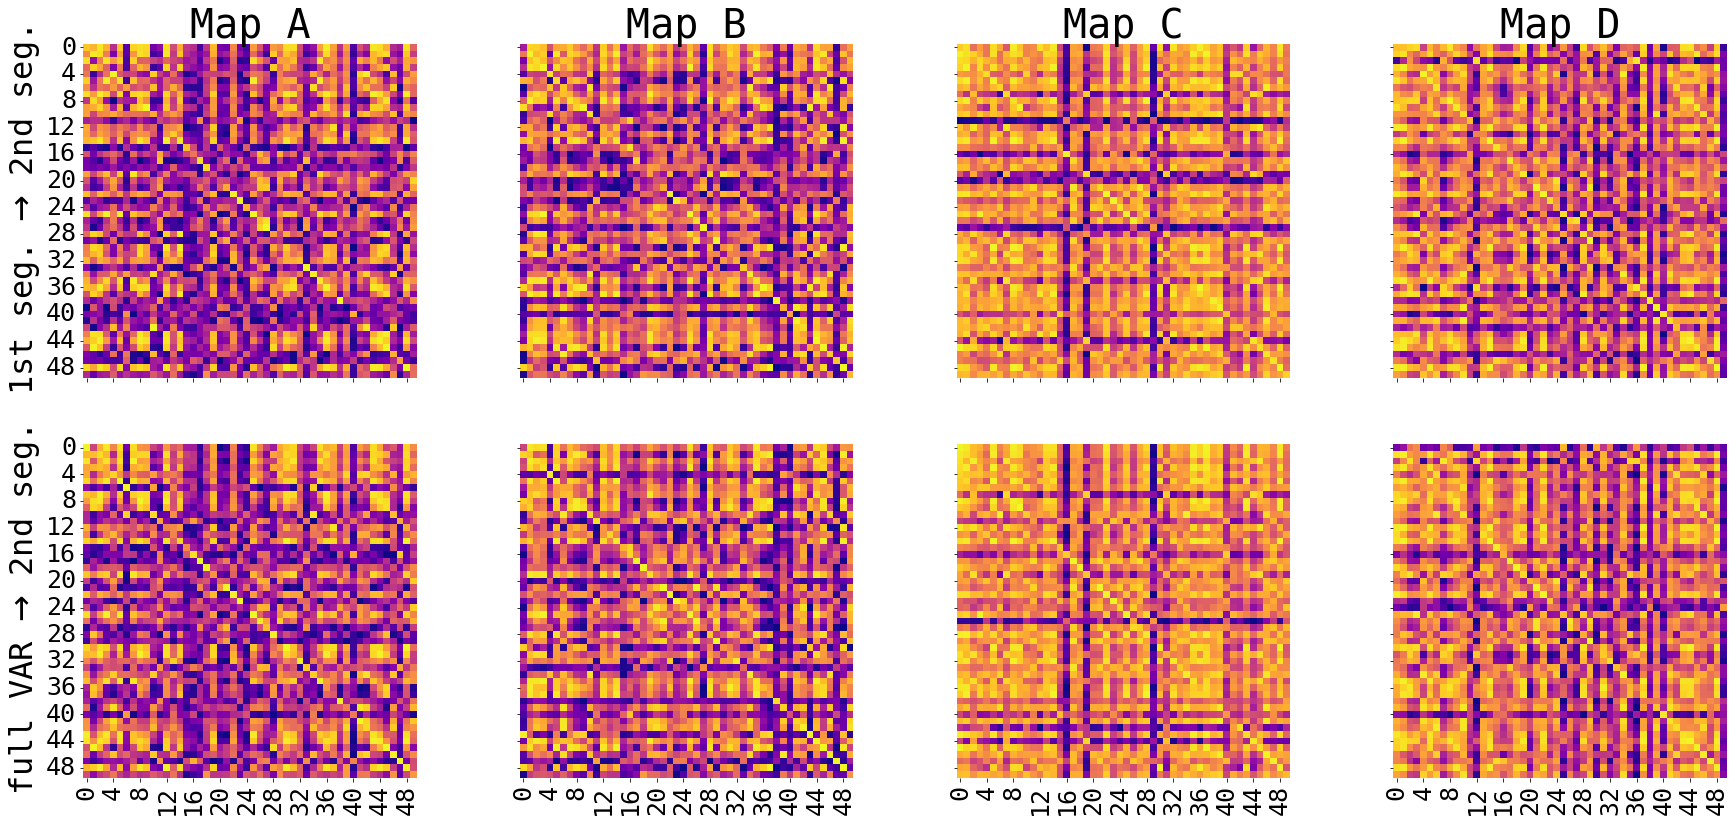

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

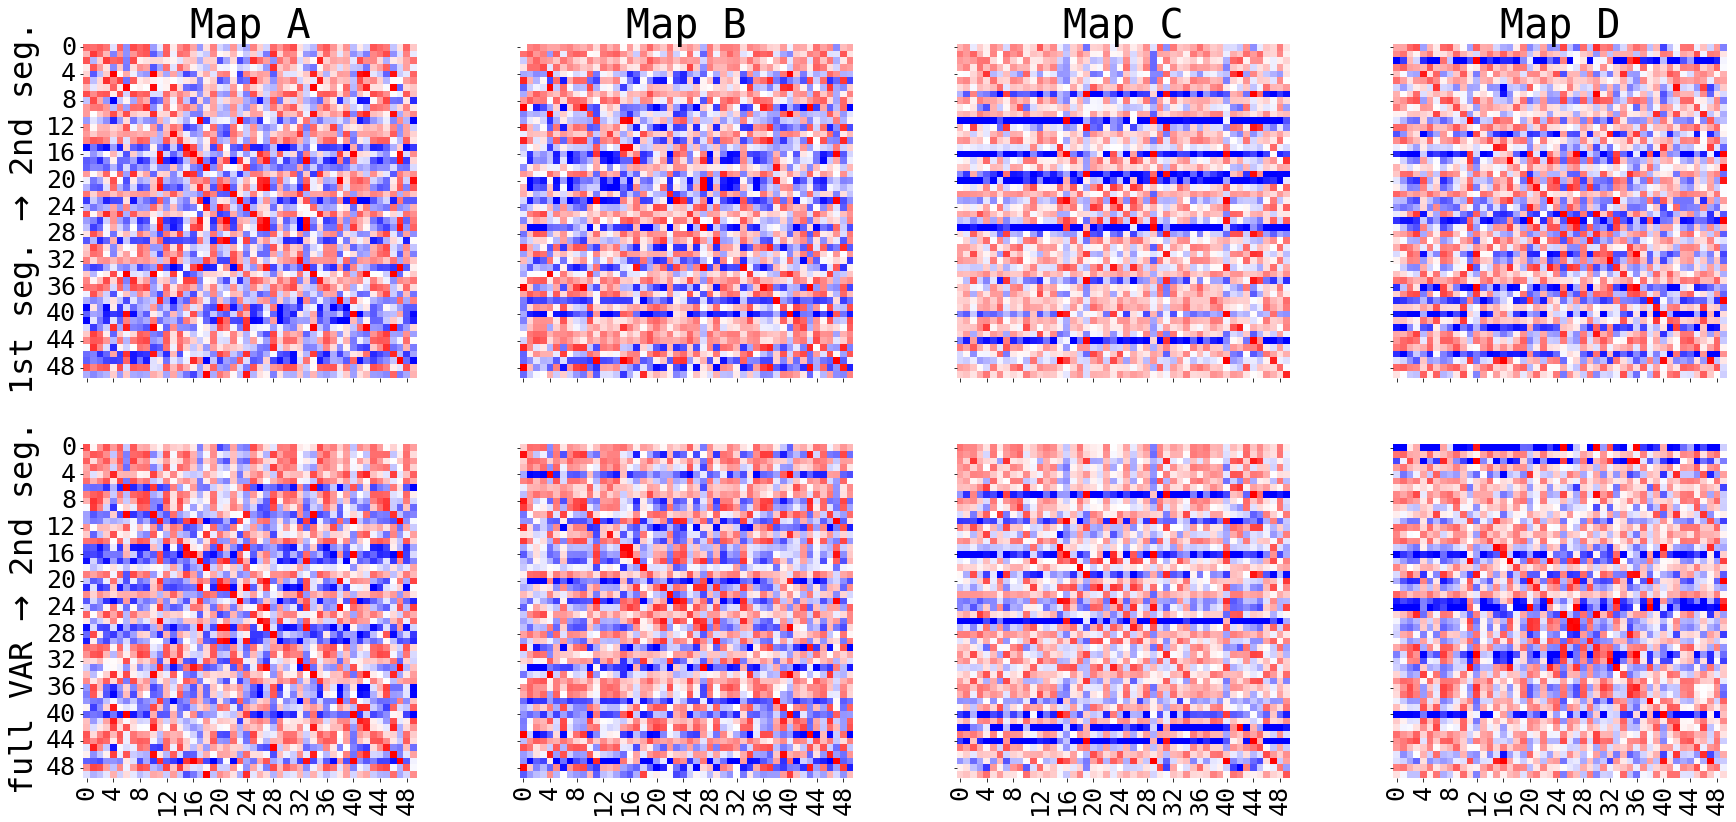

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

,A,B,C,D
1st-segment,22,23,17,22
VAR-full,25,25,18,23


,A,B,C,D
1st-segment,22,23,17,22
VAR-full,25,25,18,23


# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010005 1st-segment       A           0.789706   0.729350       0.925138   
                             B           0.789706   0.729350       0.879749   
                             C           0.789706   0.729350       0.909407   
                             D           0.789706   0.729350       0.943512   
           2nd-segment       A           0.797157   0.738480       0.944745   
...                                           ...        ...            ...   
sub-010317 VAR-segments-mean D           0.797703   0.734777       0.940268   
sub-010319 VAR-segments-mean A           0.751864   0.696872       0.724825   
                             B           0.751864   0.696872       0.843942   
                             C           0.751864   0.696872       0.927049   
                             D           0.751864   0.696872       0.873764   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010005 1st-segment       A           0.247794   12.927491  19.168028   
                             B           0.257816   12.327504  20.913925   
                             C           0.235284   12.710829  18.494097   
                             D           0.259105   13.405258  19.326979   
           2nd-segment       A           0.252772   12.277505  20.595745   
...                                           ...         ...        ...   
sub-010317 VAR-segments-mean D           0.250717   13.379442  18.754191   
sub-010319 VAR-segments-mean A           0.247367   14.252476  17.380895   
                             B           0.248696   13.897486  17.916407   
                             C           0.257247   13.835817  18.581574   
                             D           0.246690   13.217779  18.682403   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010005 1st-segment       A                0.791319       0.076675   
                             B                0.059817       0.808740   
                             C                0.069040       0.043918   
                             D                0.077365       0.077108   
           2nd-segment       A                0.805714       0.066637   
...                                                ...            ...   
sub-010317 VAR-segments-mean D                0.066572       0.071701   
sub-010319 VAR-segments-mean A                0.769291       0.087665   
                             B                0.078680       0.776390   
                             C                0.078624       0.066774   
                             D                0.069880       0.068039   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010005 1st-segment       A                0.076944       0.055062  
                             B                0.070419       0.061024  
                             C                0.783906       0.103136  
                             D                0.052492       0.793035  
           2nd-segment       A                0.076835       0.050813  
...                                                ...            ...  
sub-010317 VAR-segments-mean D                0.075249       0.786478  
sub-010319 VAR-segments-mean A                0.077216       0.065827  
                             B                0.069869       0.075061  
                             C                0.784394       0.070207  
                             D                0.076921       0.785159  

[800 rows x 10 columns]

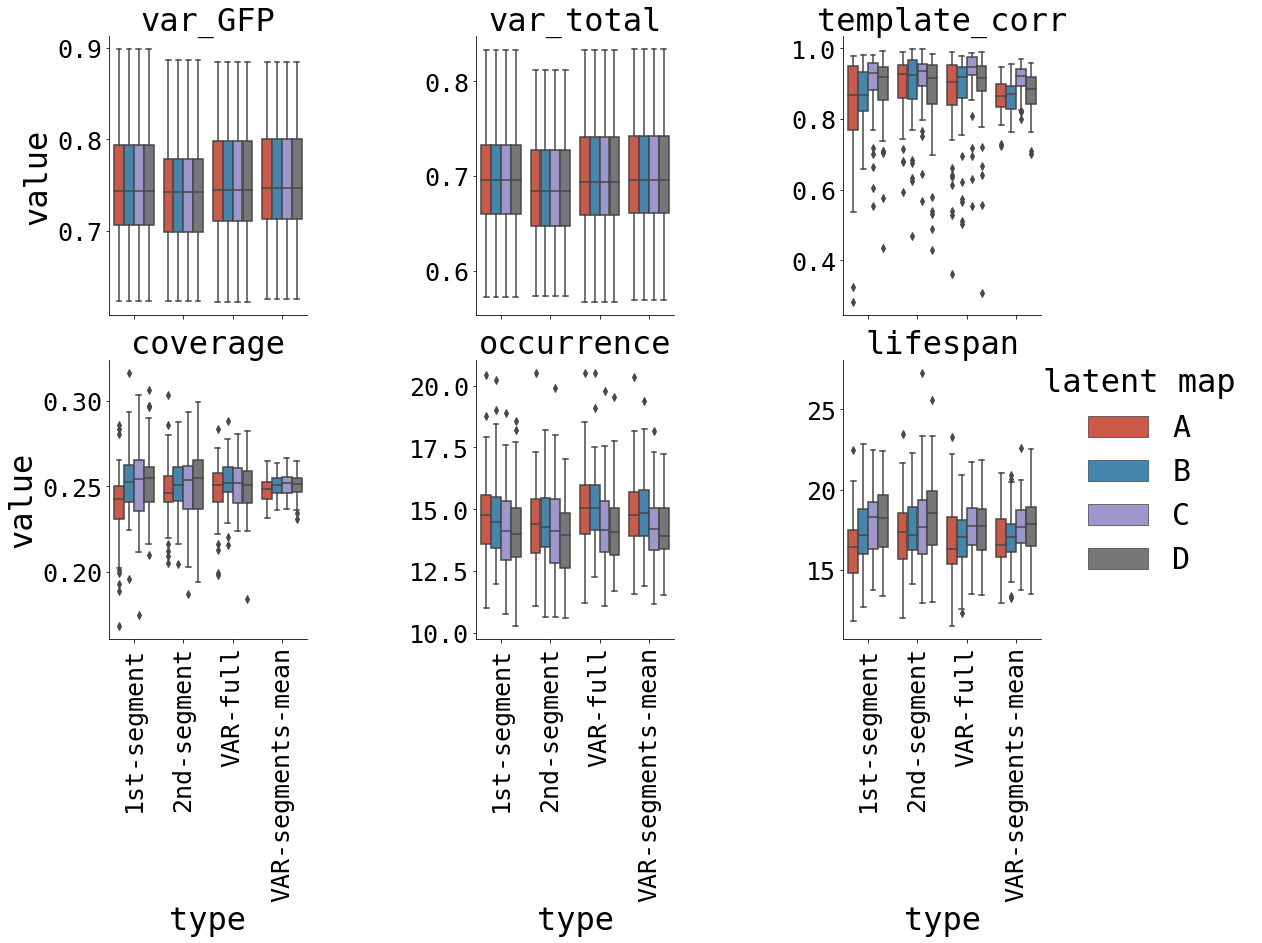

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,5.337229,0.006307,0.003815,0.510713


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,13.793402,49.0,two-sided,1.697457e-18,9.336012e-18,fdr_by,3.133e+15,0.091909
1,diffs,VAR-full,real_data,True,True,-1.000080,49.0,two-sided,3.221853e-01,5.906730e-01,fdr_by,0.246,-0.055292
2,diffs,VAR-segments,real_data,True,True,-2.632058,49.0,two-sided,1.131790e-02,3.112421e-02,fdr_by,3.379,-0.147632


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,2.723117,0.070641,0.001714,0.50427


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,20.370611,49.0,two-sided,1.441627e-25,7.928949e-25,fdr_by,2.371e+22,0.082314
1,diffs,VAR-full,real_data,True,True,-0.099694,49.0,two-sided,9.209943e-01,1.000000e+00,fdr_by,0.155,-0.005295
2,diffs,VAR-segments,real_data,True,True,-1.719765,49.0,two-sided,9.178640e-02,2.524126e-01,fdr_by,0.604,-0.089729


== template_corr ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,1.750196,0.179126,0.012691,0.759416


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-1.433599,49.0,two-sided,0.158037,0.434602,fdr_by,0.401,-0.186819
1,diffs,VAR-full,real_data,True,True,-1.514009,49.0,two-sided,0.136448,0.434602,fdr_by,0.447,-0.248839
2,diffs,VAR-segments,real_data,True,True,-0.830577,49.0,two-sided,0.410242,0.752109,fdr_by,0.213,-0.110659


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,1.714094,0.185483,0.009482,0.871589


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-1.493071,49.0,two-sided,0.141830,0.390033,fdr_by,0.434,-0.190108
1,diffs,VAR-full,real_data,True,True,0.332088,49.0,two-sided,0.741239,1.000000,fdr_by,0.162,0.044410
2,diffs,VAR-segments,real_data,True,True,2.003951,49.0,two-sided,0.050620,0.278409,fdr_by,0.967,0.235150


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,6.985021,0.001459,0.017457,0.989917


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-2.124720,49.0,two-sided,0.038679,0.106367,fdr_by,1.204,-0.170519
1,diffs,VAR-full,real_data,True,True,-3.557111,49.0,two-sided,0.000843,0.004638,fdr_by,33.178,-0.310603
2,diffs,VAR-segments,real_data,True,True,-1.705773,49.0,two-sided,0.094382,0.173034,fdr_by,0.591,-0.154378


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,9.054214,0.000246,0.016281,0.895233


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,2.103384,49.0,two-sided,0.040590,0.074414,fdr_by,1.158,0.123740
1,diffs,VAR-full,real_data,True,True,3.697074,49.0,two-sided,0.000551,0.003028,fdr_by,48.683,0.308164
2,diffs,VAR-segments,real_data,True,True,2.497389,49.0,two-sided,0.015919,0.043778,fdr_by,2.526,0.188778


In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010005 1st-segment           3.786346  1.998938          2.0   
           2nd-segment           3.869493  1.989571          2.0   
           VAR-full              4.032556  1.981451          2.0   
sub-010012 1st-segment           2.849403  1.997017          2.0   
           2nd-segment           2.983272  1.991352          2.0   
...                                   ...       ...          ...   
sub-010300 VAR-segments-mean     3.446785  1.992589          2.0   
sub-010305 VAR-segments-mean     3.662110  1.996409          2.0   
sub-010315 VAR-segments-mean     3.148745  1.996424          2.0   
sub-010317 VAR-segments-mean     3.597202  1.996552          2.0   
sub-010319 VAR-segments-mean     3.624951  1.995856          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010005 1st-segment            1.026582         1.051707          52.0  
           2nd-segment            1.018962         1.045524          52.0  
           VAR-full               1.041651         1.066491          52.0  
sub-010012 1st-segment            1.247556         1.296963          40.0  
           2nd-segment            1.237540         1.285484          40.0  
...                                    ...              ...           ...  
sub-010300 VAR-segments-mean      1.076870         1.113285          52.0  
sub-010305 VAR-segments-mean      1.040336         1.071376          56.0  
sub-010315 VAR-segments-mean      1.163889         1.205387          44.0  
sub-010317 VAR-segments-mean      1.090496         1.127856          52.0  
sub-010319 VAR-segments-mean      1.072056         1.107181          52.0  

[200 rows x 6 columns]

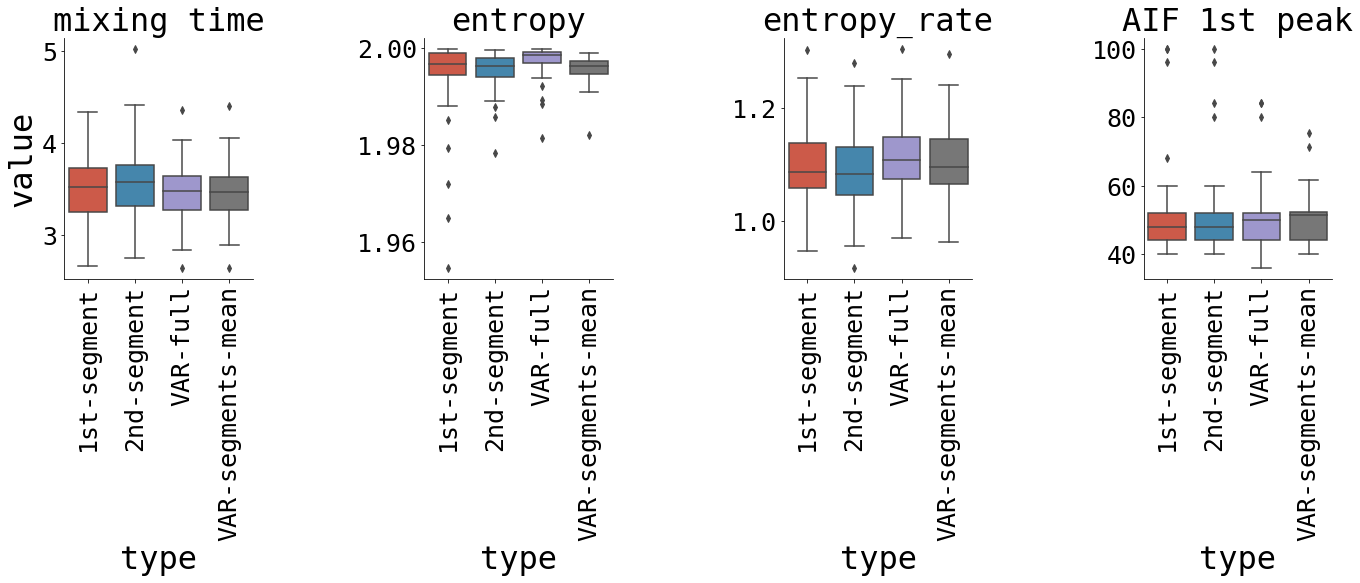

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010005,3.786346,1.998938,2.0,1.026582,1.051707,52.0,1st-segment
0,sub-010005,3.869493,1.989571,2.0,1.018962,1.045524,52.0,2nd-segment
0,sub-010005,3.878527,1.996832,2.0,1.041226,1.070349,52.0,VAR-1-segment
0,sub-010005,3.999098,1.986033,2.0,1.035905,1.063948,52.0,VAR-10-segment
0,sub-010005,3.965764,1.990850,2.0,1.017243,1.045145,56.0,VAR-11-segment
...,...,...,...,...,...,...,...,...
0,sub-010319,3.609113,1.999423,2.0,1.081015,1.116367,52.0,VAR-6-segment
0,sub-010319,3.578204,1.994501,2.0,1.072400,1.106754,52.0,VAR-7-segment
0,sub-010319,3.714777,1.999117,2.0,1.070706,1.104731,52.0,VAR-8-segment
0,sub-010319,3.511194,1.995543,2.0,1.065872,1.099696,52.0,VAR-9-segment


In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010005,0.083147,-0.009367,-0.007620,0.0,real_data
1,sub-010012,0.133869,-0.005665,-0.010016,0.0,real_data
2,sub-010021,-0.076018,-0.001529,0.005530,0.0,real_data
3,sub-010024,0.218186,0.006473,-0.004477,0.0,real_data
4,sub-010032,0.170068,-0.002119,-0.016110,-4.0,real_data
...,...,...,...,...,...,...
145,sub-010300,0.356477,0.001919,-0.047702,0.0,VAR-segments
146,sub-010305,0.284798,-0.000938,-0.003980,-4.0,VAR-segments
147,sub-010315,-0.008788,0.003260,0.019108,0.0,VAR-segments
148,sub-010317,0.110374,0.002069,-0.026516,0.0,VAR-segments


In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,4.841518,0.009882,0.022394,0.009245,0.656952,False,0.477818,2.005857e-08


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,0.533003,49.0,two-sided,0.596441,1.000000,fdr_by,0.176,0.021323
1,diffs,VAR-full,real_data,True,True,2.309312,49.0,two-sided,0.025183,0.069254,fdr_by,1.717,0.211334
2,diffs,VAR-segments,real_data,True,True,2.315028,49.0,two-sided,0.024842,0.069254,fdr_by,1.737,0.193402


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,4.37672,0.015114,0.047363,0.63064


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-3.010857,49.0,two-sided,0.004110,0.022607,fdr_by,8.133,-0.378719
1,diffs,VAR-full,real_data,True,True,-2.388736,49.0,two-sided,0.020802,0.057207,fdr_by,2.015,-0.467807
2,diffs,VAR-segments,real_data,True,True,-1.299511,49.0,two-sided,0.199850,0.366391,fdr_by,0.339,-0.241720


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,28.005928,2.398414e-10,0.047602,0.557371


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-13.265693,49.0,two-sided,7.726268e-18,4.249447e-17,fdr_by,7.207e+14,-0.307810
1,diffs,VAR-full,real_data,True,True,-6.052174,49.0,two-sided,1.944863e-07,5.348372e-07,fdr_by,7.617e+04,-0.542631
2,diffs,VAR-segments,real_data,True,True,-2.551599,49.0,two-sided,1.389390e-02,2.547214e-02,fdr_by,2.836,-0.220490


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,0.572513,0.565981,0.490332,0.002468,0.630819,False,0.414758,6.715551e-10


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-0.306891,49.0,two-sided,0.760227,1.0,fdr_by,0.161,-0.021453
1,diffs,VAR-full,real_data,True,True,0.656198,49.0,two-sided,0.514767,1.0,fdr_by,0.189,0.085954
2,diffs,VAR-segments,real_data,True,True,0.953250,49.0,two-sided,0.345142,1.0,fdr_by,0.236,0.107799
